In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from datetime import datetime
sns.set(style="whitegrid", font_scale=1.4)
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from numpy import argmax
from tqdm import trange

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
df = pd.read_csv('Data_set.csv')

In [3]:
df.head()

,Unnamed: 0,MONTH,DAY,M,BALL,SPEED_RES_PAS,SPEED_RES_FRE,SPEED_RES_EMPTY,SPEED_NORM_PAS,SPEED_NORM_FRE,...,O_4,O_T,delta_OTS_2,delta_OTS_3,delta_OTS_4,delta_O_1,delta_O_2,delta_O_3,delta_O_4,delta_O_T
0,5,1,19,1,10,1000,1000,1000,60,50,...,0,1,1,0,0,0,1,0,0,1
1,8,1,23,1,10,1000,1000,1000,140,90,...,0,1,-1,0,0,0,-1,0,0,-1
2,11,1,23,1,10,1000,1000,1000,160,90,...,0,0,-2,0,0,0,-2,0,0,-2
3,13,1,23,1,10,1000,1000,1000,160,90,...,0,0,0,0,0,0,0,0,0,0
4,15,1,23,1,10,1000,1000,1000,160,90,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# np_labels = np.array(df.TARGET)
# x = df.drop(['TARGET', 'M', 'Unnamed: 0'], axis = 1).values #returns a numpy array
# # Normalization
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# df = pd.DataFrame(x_scaled)
# np_df = df.values

np_df = df.drop(['TARGET', 'M', 'Unnamed: 0'], axis = 1).values
np_labels = np.array(df.TARGET)

In [5]:
# X_train, X_test, y_train, y_test = train_test_split(np_df, np_labels, test_size=0.2, random_state=10)

blade = 92347 # Последние полгода

# Разобьем на трейн-тест выборку
X_train, X_test, y_train, y_test = np_df[:blade], np_df[blade:], np_labels[:blade], np_labels[blade:]

In [6]:
X_train = torch.FloatTensor(X_train) 
y_train = torch.FloatTensor(y_train) 

X_test = torch.FloatTensor(X_test) 
y_test = torch.FloatTensor(y_test)

In [7]:
train_loader = torch.utils.data.DataLoader(X_train, batch_size=128)
test_loader = torch.utils.data.DataLoader(X_test, batch_size=128)

In [8]:
dim_code=2

In [9]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
 
        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(in_features=143, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=2*dim_code),
            nn.ReLU()
        )
 
        # decoder 
        self.decoder = nn.Sequential(
            nn.Linear(in_features=dim_code, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=143),
            nn.Sigmoid()
        )
        
    def encode(self, x):
        x = x.float()
        x = self.encoder(x)
        mu, logsigma = torch.split(x, dim_code, dim=1)
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(logsigma)
            eps = torch.randn_like(std)
            sample = eps * std + mu
            return sample
        else:
            return mu
    
    def decode(self, z):
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        latent_code = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decoder(latent_code)
        return mu, logsigma, reconstruction

    def get_latent_vector(self, x):
        mu, logsigma = self.encode(x)
        latent_code = self.gaussian_sampler(mu, logsigma)
        return latent_code

    def sample(self, x):
        generated = self.decoder(x)
        return generated

In [10]:
def train(model, optimizer, criterion, train_loader, val_loader, n_epochs=20):
    train_losses = []
    val_losses = []

    for epoch in trange(n_epochs):
        model.train()
        train_losses_per_epoch = []
        for X_batch in train_loader:
#             print(X_batch.max(), X_batch.min())
            optimizer.zero_grad()
            mu, logsigma, reconstruction = model(X_batch.to(device))
#             print('TRAIN', reconstruction)
            loss = criterion(X_batch.to(device).float(), mu, logsigma, reconstruction)
            loss.backward()
            optimizer.step()
            train_losses_per_epoch.append(loss.item())
        
#         print('LATENT =', model.get_latent_vector(X_batch.to(device))) # Тут не нули
        
        train_losses.append(np.mean(train_losses_per_epoch))

        model.eval()
        val_losses_per_epoch = []
        with torch.no_grad():
#             print("VALIDATION")
            for X_batch in val_loader:
              mu, logsigma, reconstruction = model(X_batch.to(device))
              loss = criterion(X_batch.to(device).float(), mu, logsigma, reconstruction)
              val_losses_per_epoch.append(loss.item())
#             print('LATENT =', model.get_latent_vector(X_batch.to(device)))
        val_losses.append(np.mean(val_losses_per_epoch))

    return train_losses, val_losses

In [11]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [12]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu**2 - torch.exp(logsigma))
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции
    """
#     loss = nn.MSELoss()
    loss = nn.BCELoss(reduction='sum')
#     print(loss(reconstruction, x), x.max())
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    KL = KL_divergence(mu, logsigma)
    log = log_likelihood(x, reconstruction)
#     print('KL =', KL)
#     print('LOG =', log)
    return KL + log

In [13]:
criterion = loss_vae

autoencoder = VAE().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters())

In [14]:
train_losses, val_losses = train(autoencoder, optimizer, criterion, 
    train_loader=test_loader, 
    val_loader=train_loader, 
    n_epochs=20)

100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


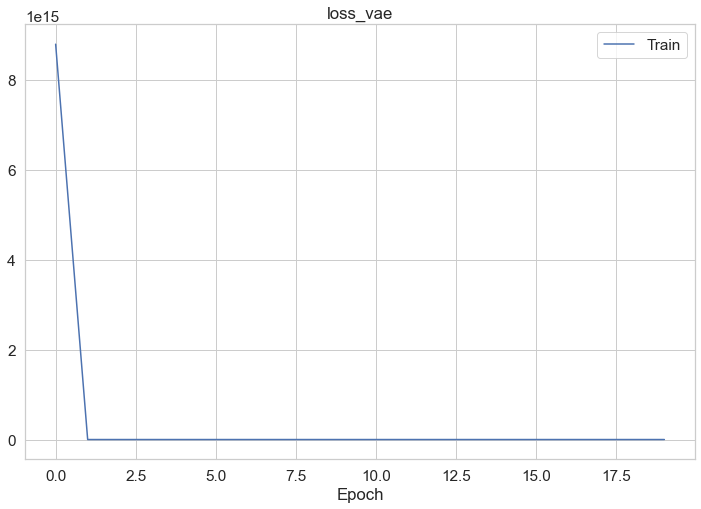

In [15]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
# plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')

plt.xlabel('Epoch')
plt.title('loss_vae')
plt.legend()
plt.show()

In [16]:
test_loader = torch.utils.data.DataLoader(X_test, batch_size=128)
y_test_loader = torch.utils.data.DataLoader(y_test, batch_size=128)

test_loader = iter(test_loader)
y_test_loader = iter(y_test_loader)

X_batch, y_batch = next(zip(test_loader, y_test_loader))

In [17]:
model = autoencoder
latent_vector_list = model.get_latent_vector(X_batch.to(device))
labels = y_batch.reshape(-1, 1)
for X_batch, y_batch in zip(test_loader, y_test_loader):
    batch_sample = model.get_latent_vector(X_batch.to(device))
    latent_vector_list = torch.vstack((latent_vector_list, batch_sample))
    labels = torch.vstack((labels, y_batch.reshape(-1, 1)))

In [18]:
latent_vector_list = latent_vector_list.detach().cpu()
labels = labels.detach().cpu()

In [19]:
labels = labels.int()
labels.dtype

torch.int32

In [20]:
latent_vector_list.shape, labels.shape

(torch.Size([15250, 2]), torch.Size([15250, 1]))

In [21]:
# X_embedded = TSNE(n_components=2).fit_transform(latent_vector_list)
# X_embedded.shape

In [22]:
# plt.figure(figsize=[20, 10])
# graph = plt.scatter(X_embedded[:,0], X_embedded[:,1], c=labels.reshape(-1), cmap='summer')
# plt.colorbar(graph)
# plt.show()

# plt.figure(figsize=[20, 10])
# graph = plt.scatter(latent_vector_list[:,0], latent_vector_list[:,1], c=labels.reshape(-1), cmap='summer')
# plt.colorbar(graph)
# plt.show()

Посчитаем средний вектор (mu) латентного пространства для объектов у которых TARGET=1 и отдельно для TARGET=0.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(np_df, np_labels, test_size=0.2, random_state=10)

# blade = 92347 # Последние полгода

# # Разобьем на трейн-тест выборку
# X_train, X_test, y_train, y_test = np_df[:blade], np_df[blade:], np_labels[:blade], np_labels[blade:]

In [24]:
X_zeros = []
X_ones = []

for x, y in zip(X_train, y_train):
    if y == 0:
        X_zeros.append(x)
    else:
        X_ones.append(x)

In [25]:
X_zeros = torch.utils.data.DataLoader(torch.FloatTensor(X_zeros), batch_size=32)
X_ones = torch.utils.data.DataLoader(torch.FloatTensor(X_ones), batch_size=32)

In [26]:
X_zeros = iter(X_zeros)
X_ones = iter(X_ones)

In [27]:
X_zeros_batch = next(X_zeros)
X_ones_batch = next(X_ones)

In [28]:
model = autoencoder

In [29]:
latent_zeros_list = model.get_latent_vector(X_zeros_batch)
latent_ones_list = model.get_latent_vector(X_ones_batch)

In [30]:
latent_zeros_list.shape, latent_ones_list.shape

(torch.Size([32, 2]), torch.Size([32, 2]))

In [31]:
latent_zeros_list

tensor([[ 0.0000,  6.2272],
        [ 0.0000,  5.3701],
        [ 0.0000,  6.2016],
        [ 0.0000, 13.5732],
        [ 0.0000,  6.2864],
        [ 0.0000,  5.7197],
        [ 0.0000,  5.7347],
        [ 0.0000,  5.7294],
        [ 0.0000,  5.6729],
        [ 0.0000,  6.1512],
        [ 0.0000,  6.5919],
        [ 0.0000,  5.7145],
        [ 0.0000,  5.6857],
        [ 0.0000,  6.5963],
        [ 0.0000,  5.6918],
        [ 0.0000,  6.5656],
        [ 0.0000,  5.6861],
        [ 0.0000,  5.7035],
        [ 0.0000,  6.2738],
        [ 0.0000,  6.0734],
        [ 0.0000,  5.6412],
        [ 0.0000,  5.2818],
        [ 0.0000,  6.1880],
        [ 0.0000,  5.7453],
        [ 0.0000,  6.2938],
        [ 0.0000,  5.7048],
        [ 0.0000,  5.7327],
        [ 0.0000,  4.8854],
        [ 0.0000,  6.4911],
        [ 0.0000,  5.6932],
        [ 0.0000,  6.2707],
        [ 0.0000,  6.5164]], grad_fn=<SplitBackward>)

In [32]:
for X_zeros_batch in X_zeros:
#     print(X_zeros_batch) тут все ок, не нули
    zeros_sample = model.get_latent_vector(X_zeros_batch)
#     print(zeros_sample) тут везде нули
    latent_zeros_list = torch.vstack((latent_zeros_list, zeros_sample))
    
for X_ones_batch in X_ones:
    ones_sample = model.get_latent_vector(X_ones_batch)
    latent_ones_list = torch.vstack((latent_ones_list, ones_sample))

In [33]:
latent_zeros_list.shape, latent_ones_list.shape

(torch.Size([73748, 2]), torch.Size([12329, 2]))

In [34]:
mean_zeros = latent_zeros_list.mean(dim=0)
mean_ones = latent_ones_list.mean(dim=0)

In [35]:
mean_zeros, mean_ones

(tensor([2.7492e-03, 6.9341e+00], grad_fn=<MeanBackward1>),
 tensor([0.0136, 6.8858], grad_fn=<MeanBackward1>))

In [36]:
SMOOTH = 1e-6

In [37]:
def cosine(a, b):
    num = (a * b).sum()
    den = (a**2 + SMOOTH).sum().sqrt() * (b**2 + SMOOTH).sum().sqrt()
    return num / (den )

In [38]:
X_test.shape

(21520, 143)

In [39]:
test_loader = torch.utils.data.DataLoader(torch.FloatTensor(X_test), batch_size=15250)
y_test_loader = torch.utils.data.DataLoader(torch.FloatTensor(y_test), batch_size=15250)

# test_loader = torch.utils.data.DataLoader(torch.FloatTensor(X_train), batch_size=32)
# y_test_loader = torch.utils.data.DataLoader(torch.FloatTensor(y_train), batch_size=32)

In [40]:
def cos_dist(X_batch, y):
    X_batch = iter(X_batch)
    x = next(X_batch)
    res = cosine(x, y)
    
    for x in X_batch:
        res = torch.vstack((res, cosine(x, y)))
        
    return res

In [41]:
for X_batch, y_batch in zip(test_loader, y_test_loader):
#     print(X_batch)
    output = model.get_latent_vector(X_batch)
#     print(output)
    preds_zeros = cos_dist(output.detach(), mean_zeros.detach())
#     print(preds_zeros)
    preds_ones = cos_dist(output.detach(), mean_ones.detach())
#     print(preds_ones)
    
    # make probabilty in the range [0, 1]
    preds = torch.hstack((preds_ones, preds_zeros)) / (preds_zeros + preds_ones)
    break

In [42]:
preds = preds.detach().cpu().numpy()

In [43]:
preds[:,0].shape

(15250,)

In [44]:
preds[100:120,0]

array([0.49999955, 0.49999952, 0.49999952, 0.49999955, 0.49999952,
       0.49999952, 0.49999952, 0.49999952, 0.49999952, 0.49999955,
       0.49999952, 0.49999955, 0.4999995 , 0.4999995 , 0.49999952,
       0.49999952, 0.49999952, 0.49999955, 0.49999952, 0.4999995 ],
      dtype=float32)

In [45]:
test_auc = roc_auc_score(y_batch, preds[:,0])

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
fpr, tpr, th = roc_curve(y_batch, preds[:,0])
gmeans = np.sqrt(tpr * (1-fpr))
ix = argmax(gmeans)

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_batch, preds[:,0])[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
plt.plot(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Норм

1. MSE 20epoch dim=6 nan
2. BCE 20epoch dim=6 nan

Везде наны, т.к. центрирует mu=0


In [ ]:
Не норм